## Data Cleaning & Dataframe Prep

This notebook handles the following tasks and prepares the data for the analysis.
If you something off, please fix it and add it to here.

Data Cleaning

- Delete NaN entries.
- Assign 0: Not Applicable to the Empirical Novelty that has been chosen as "Not Applicaple". We have observed that this occurs when reviewers think empirical novelty is not applicaple to a paper, which can be a theoretical one for instance. When calculating the mean of this, please do not include 0 entries.
- Ethics Flags include data which says both NO. and Yes, ... All of the contradictory entries included explanations, so we have accepted them as Yes.
- Delete reviews submitted after the deadline

Data Preparation

- Statistics related to each reviewer is calculated for each paper.
- These statics are: std, mean, diff(max_score-min_score)

### Resulting datasets

- review_df_clean -> reviewer per row cleaned data
- paper_df -> per paper dataframe, statistics are calculated such as mean, std, variance, max_min difference etc.
- df -> basic dataset

In [73]:
import pandas as pd 
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt

file_name = "../data/ICLR.cc-2023-Conference.csv"
df = pd.read_csv(file_name)

In [74]:
df.columns = df.columns.str.replace("recommendation", "score", regex=False)

### Dataframe 1: Reviewers as rows

In [75]:
# Instead of one row per paper, arrange data to have one reviewer per row.

reviewer_feature_cols = [col.split('reviewer1_')[1] for col in df.columns if col.startswith('reviewer1')]
for i in reviewer_feature_cols:
    print(i)
reviewer_cols = [col for col in df.columns for i in range(1, 5) if col.startswith('reviewer' + str(i) + '_')]
non_reviewer_cols = [col for col in df.columns if col not in reviewer_cols]


df['paper_id'] = np.arange(len(df))
review_df = pd.DataFrame(columns=['paper_id', 'reviewer', 'reviewer_score', 'reviewer_confidence', 'reviewer_summary_of_the_paper', 'reviewer_strength_and_weaknesses', 'reviewer_clarity_quality_novelty_and_reproducibility', 'reviewer_summary_of_the_review', 'reviewer_correctness', 'reviewer_technical_novelty_and_significance', 'reviewer_empirical_novelty_and_significance', 'reviewer_flag_for_ethics_review', 'reviewer_length', 'reviewer_cdate', 'reviewer_tmdate', 'title', 'keywords', 'TL;DR', 'abstract', 'cdate', 'tmdate', 'decision'])
for idx, row in df.iterrows():
    for i in range(1, 5):
        dict_ = {}
        for col in reviewer_feature_cols:
            dict_['reviewer'] = i
            dict_['reviewer' + '_' + col] = row['reviewer' + str(i) + '_' + col]
        for col in non_reviewer_cols:
            dict_[col] = row[col]
        dict_['paper_id'] = row['paper_id']
        review_df.loc[len(review_df)] = dict_

df.head()

score
confidence
summary_of_the_paper
strength_and_weaknesses
clarity_quality_novelty_and_reproducibility
summary_of_the_review
correctness
technical_novelty_and_significance
empirical_novelty_and_significance
flag_for_ethics_review
length
cdate
tmdate


,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,reviewer1_clarity_quality_novelty_and_reproducibility,reviewer1_summary_of_the_review,reviewer1_correctness,reviewer1_technical_novelty_and_significance,reviewer1_empirical_novelty_and_significance,reviewer1_flag_for_ethics_review,reviewer1_length,reviewer1_cdate,reviewer1_tmdate,reviewer2_score,reviewer2_confidence,reviewer2_summary_of_the_paper,reviewer2_strength_and_weaknesses,reviewer2_clarity_quality_novelty_and_reproducibility,reviewer2_summary_of_the_review,reviewer2_correctness,reviewer2_technical_novelty_and_significance,reviewer2_empirical_novelty_and_significance,reviewer2_flag_for_ethics_review,reviewer2_length,reviewer2_cdate,reviewer2_tmdate,reviewer3_score,reviewer3_confidence,reviewer3_summary_of_the_paper,reviewer3_strength_and_weaknesses,reviewer3_clarity_quality_novelty_and_reproducibility,reviewer3_summary_of_the_review,reviewer3_correctness,reviewer3_technical_novelty_and_significance,reviewer3_empirical_novelty_and_significance,reviewer3_flag_for_ethics_review,reviewer3_length,reviewer3_cdate,reviewer3_tmdate,reviewer4_score,reviewer4_confidence,reviewer4_summary_of_the_paper,reviewer4_strength_and_weaknesses,reviewer4_clarity_quality_novelty_and_reproducibility,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_id
0,Guiding Safe Exploration with Weakest Precondi...,reinforcement learning; safe learning; safe ex...,"We use an online, weakest-precondition-based a...",In reinforcement learning for safety-critical ...,2022-09-22 14:36:24,2024-11-25 10:13:40,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...",This paper deals with safe exploration in rein...,### Strength\n- Interesting and importance pro...,### Clarity\nThis paper is mostly well-written...,"Though this paper presents a new, promising me...",2: Several of the paper’s claims are incorrect...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3055,2022-10-20 09:40:48,2022-11-23 10:36:28,"8: accept, good paper",3: You are fairly confident in your assessment...,This paper adapts ideas from formal program an...,# Strengths\n\nThe technique is well motivated...,The technique and motivation are clearly commu...,The paper contributes a novel algorithm for cr...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,3: The contributions are significant and somew...,NO.,3272,2022-10-25 00:42:31,2022-10-25 00:42:31,6: marginally above the acceptance threshold,3: You are fairly confident in your assessment...,The paper proposes a method for safe reinforce...,+ The approach reduces the number of safety vi...,The paper is overall well written and presente...,The paper builds on previous work on safe rein...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,1508.0,2022-10-26 00:04:46,2022-10-26 00:04:46,6: marginally above the acceptance threshold,"4: You are confident in your assessment, but n...","The paper proposes a safe RL algorithm, Symbol...",Strengths:\n* SPICE’s use of formal methods pr...,The paper is generally clear. I appreciate the...,I like the proposed approach and its associate...,4: All of the claims and statements are well-s...,3: The contributions are significant and somew...,2: The contributions are only marginally signi...,NO.,3082.0,2022-11-03 08:08:39,2022-12-14 03:46:36,Accept: poster,0
1,An Adaptive Entropy-Regularization Framework f...,Multi-Agent Reinforcement Learning; Entropy Re...,This paper proposes an adaptive entropy-regul...,"In this paper, we propose 

### Data prep: convert and simplify column values 

1. Convert cdate to pandas datetime datatype.
2. Add time_to_deadline column which measures the time difference between the review submission and review deadline
3. To get the score part, remove the explanations from score columns such as recommendation.
4. Add a is_high_variance column to detect high discrepancy reviews.
5. There are different acceptances, like top-5-notable etc. We just treat them as expected, so simply those explanations.

In [76]:
df['reviewer1_cdate'] = pd.to_datetime(df['reviewer1_cdate'])
df['reviewer2_cdate'] = pd.to_datetime(df['reviewer2_cdate'])
df['reviewer3_cdate'] = pd.to_datetime(df['reviewer3_cdate'])
df['reviewer4_cdate'] = pd.to_datetime(df['reviewer4_cdate'])

df['reviewer1_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer1_cdate']
df['reviewer2_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer2_cdate']
df['reviewer3_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer3_cdate']
df['reviewer4_time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - df['reviewer4_cdate']

df.dropna(subset=['reviewer1_cdate', 'reviewer2_cdate', 'reviewer3_cdate', 'reviewer4_cdate'], how='all', inplace=True)

def get_scores_from_str(x):
    if isinstance(x, str):
        return int(x.split(':')[0])
    else:
        return np.nan
    
df['reviewer1_score'] = df['reviewer1_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer2_score'] = df['reviewer2_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer3_score'] = df['reviewer3_score'].apply(lambda x: get_scores_from_str(x))
df['reviewer4_score'] = df['reviewer4_score'].apply(lambda x: get_scores_from_str(x))

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

df['max_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].max(axis=1)
df['min_score'] = df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']].min(axis=1)
df['max_min_score_diff'] = df['max_score'] - df['min_score']

df['is_high_variance'] = df['max_min_score_diff'] >= 4

df['decision'] = df['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")

Play with variables and check if the values are as expected:

In [77]:
df[df['decision'].eq("Accept") & df['is_high_variance']]

,title,keywords,TL;DR,abstract,cdate,tmdate,reviewer1_score,reviewer1_confidence,reviewer1_summary_of_the_paper,reviewer1_strength_and_weaknesses,reviewer1_clarity_quality_novelty_and_reproducibility,reviewer1_summary_of_the_review,reviewer1_correctness,reviewer1_technical_novelty_and_significance,reviewer1_empirical_novelty_and_significance,reviewer1_flag_for_ethics_review,reviewer1_length,reviewer1_cdate,reviewer1_tmdate,reviewer2_score,reviewer2_confidence,reviewer2_summary_of_the_paper,reviewer2_strength_and_weaknesses,reviewer2_clarity_quality_novelty_and_reproducibility,reviewer2_summary_of_the_review,reviewer2_correctness,reviewer2_technical_novelty_and_significance,reviewer2_empirical_novelty_and_significance,reviewer2_flag_for_ethics_review,reviewer2_length,reviewer2_cdate,reviewer2_tmdate,reviewer3_score,reviewer3_confidence,reviewer3_summary_of_the_paper,reviewer3_strength_and_weaknesses,reviewer3_clarity_quality_novelty_and_reproducibility,reviewer3_summary_of_the_review,reviewer3_correctness,reviewer3_technical_novelty_and_significance,reviewer3_empirical_novelty_and_significance,reviewer3_flag_for_ethics_review,reviewer3_length,reviewer3_cdate,reviewer3_tmdate,reviewer4_score,reviewer4_confidence,reviewer4_summary_of_the_paper,reviewer4_strength_and_weaknesses,reviewer4_clarity_quality_novelty_and_reproducibility,reviewer4_summary_of_the_review,reviewer4_correctness,reviewer4_technical_novelty_and_significance,reviewer4_empirical_novelty_and_significance,reviewer4_flag_for_ethics_review,reviewer4_length,reviewer4_cdate,reviewer4_tmdate,decision,paper_id,reviewer1_time_to_deadline,reviewer2_time_to_deadline,reviewer3_time_to_deadline,reviewer4_time_to_deadline,max_score,min_score,max_min_score_diff,is_high_variance
9,Improved Training of Physics-Informed Neural N...,Physics-informed neural networks; electrical i...,NaN,Physics-informed neural networks (PINNs) are a...,2022-09-22 14:42:07,2023-02-26 07:06:29,10,"4: You are confident in your assessment, but n...",The manuscript is using PINN to solve the prob...,This is an excellent paper. Introduction of th...,High quality paper trying to stuff a lot of in...,Excellent and informative paper.,4: All of the claims and statements are well-s...,"4: The contributions are significant, and do n...","4: The contributions are significant, and do n...",NO.,1364,2022-10-24 18:52:56,2022-10-24 18:52:56,6,3: You are fairly confident in your assessment...,This paper introduces the use of Bayesian appr...,Strengths:\n1.\tThe proposed approach was demo...,The paper is well written> the use of EB: prio...,The authors present an interesting approach fo...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,3: The contributions are significant and somew...,NO.,2090,2022-10-24 22:45:31,2022-10-24 22:45:31,8.0,3: You are fairly confident in your assessment...,This paper proposes to incorporate energy-base...,Strength:\n- The paper is well written and org...,The paper is well written and organized. It pr...,The paper studies an interesting problem and p...,3: Some of the paper’s claims have minor issue...,3: The contributions are significant and somew...,3: The contributions are significant and somew...,NO.,3781.0,2022-10-30 05:41:08,2022-12-08 21:57:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,Accept,9,11 days 06:07:04,11 days 02:14:29,5 days 19:18:52,NaT,10.0,6.0,4.0,True
32,PD-MORL: Preference-Driven Multi-Objective Rei...,multi-objective reinforcement learning; MORL; ...,A novel approach that obtains a single policy ...,Multi-objective reinforcement learning (MORL) ...,2022-09-22 14:37:04,2023-03-02 03:46:32,8,3: You are fairly confident in your assessment...,This work proposes an algorithm for solving mu...,The main strengths of this paper:\n- Novel app...,"Besides the main weakness described above, the...","This work provides a strong contribution, back...",4: All of the claims and statements are well-s...,3: The contributi

In [78]:
df[['reviewer1_score', 'reviewer2_score', 'reviewer3_score', 'reviewer4_score']]

,reviewer1_score,reviewer2_score,reviewer3_score,reviewer4_score
0,6,8,6.0,6.0
1,3,8,6.0,NaN
2,5,6,3.0,3.0
3,8,8,8.0,8.0
4,3,3,3.0,6.0
...,...,...,...,...
3791,3,3,5.0,NaN
3792,1,6,6.0,3.0
3793,6,6,8.0,6.0
3794,6,3,3.0,3.0


### Data Cleaning

1. Clean reviews submitted after the deadline

In [79]:
review_df['reviewer_cdate'] = pd.to_datetime(review_df['reviewer_cdate'])
review_df_clean = review_df[review_df['reviewer_cdate'] < pd.to_datetime('2022-11-05 01:00:00')]
review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/3064297660.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.dropna(subset=['reviewer_cdate'], inplace=True)


2. Treat contradictiory ethis flags as Yes, because all of them include explanation.

In [80]:
review_df_clean.value_counts('reviewer_flag_for_ethics_review')
review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/2241807063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_flag_for_ethics_review'] = review_df_clean['reviewer_flag_for_ethics_review'].apply(lambda x: 1 if 'yes' in str(x).lower() else 0)


3. Assign 0 to Not applicaple papers for Empirical Novelty and Significance. These are generally treated as theoretical papers by the reviewers.

In [81]:
print(review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts())
review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)
review_df_clean['reviewer_empirical_novelty_and_significance'].value_counts()

review_df_clean.reset_index(drop=True, inplace=True)

reviewer_empirical_novelty_and_significance
3: The contributions are significant and somewhat new. Aspects of the contributions exist in prior work.    5895
2: The contributions are only marginally significant or novel.                                              5270
Not applicable                                                                                              1075
4: The contributions are significant, and do not exist in prior works.                                      1018
1: The contributions are neither significant nor novel.                                                      621
Name: count, dtype: int64


/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/2876056155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['reviewer_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: "0: Not Applicable" if x == "Not applicable" else x)


4. Add time_to_deadline column

In [82]:
review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/2658128959.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['time_to_deadline'] = pd.to_datetime('2022-11-05 01:00:00') - review_df_clean['reviewer_cdate']


5. Convert string numbers to integers.

In [83]:
review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)

review_df_clean['review_score'] = review_df_clean['reviewer_score'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_score'], inplace=True)

review_df_clean['review_correctness'] = review_df_clean['reviewer_correctness'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_correctness'], inplace=True)

review_df_clean['review_technical_novelty_and_significance'] = review_df_clean['reviewer_technical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_technical_novelty_and_significance'], inplace=True)

review_df_clean['review_empirical_novelty_and_significance'] = review_df_clean['reviewer_empirical_novelty_and_significance'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
review_df_clean.drop(columns=['reviewer_empirical_novelty_and_significance'], inplace=True)

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/3490803434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['review_confidence'] = review_df_clean['reviewer_confidence'].apply(lambda x: x.split(':')[0].strip() if pd.notnull(x) else x).astype(int)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/3490803434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean.drop(columns=['reviewer_confidence'], inplace=True)
/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/3490803434.py:4: SettingW

6. Make all decisions have only "Accept"
7. Add high_variance information by joining on paper_id

In [84]:
review_df_clean['decision'] = review_df_clean['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")
review_df_clean = pd.merge(review_df_clean, df[['paper_id', 'is_high_variance']], on='paper_id', how='right')

/var/folders/fl/8ng_m3ld6734_9svpd_k619m0000gn/T/ipykernel_30213/1487152142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df_clean['decision'] = review_df_clean['decision'].apply(lambda x: "Accept" if "accept" in x.lower() else "Reject")


## Reviewer Dataset is completed

### Dataframe 2: Papers as rows and reviewer statistics per paper

Use aggregation functions to calculate statistics per paper.
- If you want to add a statistic or change one, add it to the lists next to the column names.

In [85]:
paper_df = review_df_clean.groupby('paper_id').agg({'time_to_deadline': ['std', 'mean'], 
                                                    'review_confidence': ['std', 'mean'],
                                                    'review_score': ['std', 'mean', 'max', 'min'],
                                                    'review_correctness': ['std', 'mean'],
                                                    'review_technical_novelty_and_significance': ['std', 'mean'],
                                                    'review_empirical_novelty_and_significance': ['std', 'mean'],
                                                    'reviewer': 'count',
                                                    'decision': 'first'}).reset_index()

paper_df["reviewer1_score"] = df["reviewer1_score"] 
paper_df["reviewer2_score"] = df["reviewer2_score"] 
paper_df["reviewer3_score"] = df["reviewer3_score"] 
paper_df["reviewer4_score"] = df["reviewer4_score"]

In [86]:
pd.set_option('display.max_columns', None)
paper_df

paper_id          time_to_deadline                             \
                                    std                       mean   
0           0 5 days 19:16:10.689828726            9 days 14:20:49   
1           1 2 days 06:32:55.872867145 12 days 22:53:01.333333333   
2           2 1 days 12:54:38.117582429     9 days 09:35:52.250000   
3           3 2 days 13:20:58.514324593    11 days 04:09:52.500000   
4           4 5 days 09:23:30.024963235    12 days 02:20:32.750000   
...       ...                       ...                        ...   
3791     3791 5 days 23:13:08.435799653 16 days 11:16:41.666666666   
3792     3792 4 days 09:28:45.175281084    11 days 22:56:18.250000   
3793     3793 1 days 20:41:21.379731310    11 days 20:54:33.750000   
3794     3794 3 days 09:33:53.422118322     8 days 04:57:49.750000   
3795     3795 7 days 04:45:12.891550738           11 days 06:42:36   

     review_confidence           review_score                    \
                   std      mean          std      mean max min   
0             0.577350  3.500000     1.000000  6.500000   8   6   
1             0.577350  3.666667     2.516611  5.666667   8   3   
2             0.500000  4.750000     1.500000  4.250000   6   3   
3             0.500000  3.250000     0.000000  8.000000   8   8   
4             0.500000  3.750000     1.500000  3.750000   6   3   
...                ...       ...          ...       ...  ..  ..   
3791          0.000000  4.000000     1.154701  3.666667   5   3   
3792          0.816497  3.000000     2.449490  4.000000   6   1   
3793          0.577350  3.500000     1.000000  6.500000   8   6   
3794          0.000000  4.000000     1.500000  3.750000   6   3   
3795          0.000000  4.000000     0.577350  5.666667   6   5   

     review_correctness           review_technical_novelty_and_significance  \
                    std      mean                                       std   
0              1.000000  3.500000                                  0.000000   
1              1.154701  3.333333                                  1.000000   
2              0.500000  2.750000                                  0.816497   
3              0.577350  3.500000                                  0.577350   
4              0.577350  3.500000                                  0.000000   
...                 ...       ...                                       ...   
3791           0.577350  3.333333                                  0.577350   
3792           1.290994  2.500000                                  0.500000   
3793           0.577350  3.500000                                  0.500000   
3794           0.816497  3.000000                                  0.577350   
3795           0.577350  2.666667                                  0.577350   

               review_empirical_novelty_and_significance           reviewer  \
          mean                                       std      mean    count   
0     3.000000                                  0.500000  2.250000        4   
1     3.000000                                  0.577350  2.333333        3   
2     2.000000                                  0.577350  1.500000        4   
3     3.500000                                  2.309401  2.000000        4   
4     2.000000                                  1.000000  1.500000        4   
...        ...                                       ...       ...      ...   
3791  2.666667                                  1.154701  0.666667        3   
3792  2.750000                                  1.000000  0.500000        4   
3793  2.250000                                  1.414214  2.000000        4   
3794  2.500000                                  0.577350  2.500000        4   
3795  2.666667                                  0.577350  2.666667        3   

     decision reviewer1_score reviewer2_score reviewer3_score reviewer4_score  
        first                                                                  
0     

Add max-min difference column. This is our most basic metric for measuring discrepancy.

In [87]:
paper_df['review_score', 'max_min_diff'] = paper_df['review_score', 'max'] - paper_df['review_score', 'min']

Add high discrepancy papers.

In [88]:
paper_df['is_high_discrepancy'] = (paper_df['review_score', 'max_min_diff'] >= 4).astype(int)

## Paper Dataset is completed

In [89]:
print(paper_df.head())

print("See the portion of papers accepted and rejected and has high discrepancy.")
print(paper_df.groupby(('decision', 'first'))['is_high_discrepancy'].mean())

  paper_id          time_to_deadline                             \
                                 std                       mean   
0        0 5 days 19:16:10.689828726            9 days 14:20:49   
1        1 2 days 06:32:55.872867145 12 days 22:53:01.333333333   
2        2 1 days 12:54:38.117582429     9 days 09:35:52.250000   
3        3 2 days 13:20:58.514324593    11 days 04:09:52.500000   
4        4 5 days 09:23:30.024963235    12 days 02:20:32.750000   

  review_confidence           review_score                    \
                std      mean          std      mean max min   
0           0.57735  3.500000     1.000000  6.500000   8   6   
1           0.57735  3.666667     2.516611  5.666667   8   3   
2           0.50000  4.750000     1.500000  4.250000   6   3   
3           0.50000  3.250000     0.000000  8.000000   8   8   
4           0.50000  3.750000     1.500000  3.750000   6   3   

  review_correctness           review_technical_novelty_and_significance       \


# Investigating Topic Popularity

First of all, we need a way to cluster the keywords together to from bigger topic groups. 

For instance, reinforcement learning should include topics such as offline reinforcement learning, policy optimization etc.

In [90]:
seed = 42
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(seed=seed)

In [91]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering, KMeans

# Load model and encode keywords
model = SentenceTransformer('all-mpnet-base-v2')  # Choose a suitable model

def split_and_normalize(kw_string):
    if pd.isna(kw_string):
        return []
    tokens = kw_string.split(";")
    return [t.strip().lower() for t in tokens if t.strip()]

keyword_list = df["keywords"].apply(split_and_normalize)

all_keywords = []
for kw_list in keyword_list:
    all_keywords.extend(kw_list)

embeddings = model.encode(all_keywords)

In [92]:
# Clustering
clustering = KMeans(n_clusters=30, random_state=seed)  # Adjust threshold
clusters = clustering.fit_predict(embeddings)

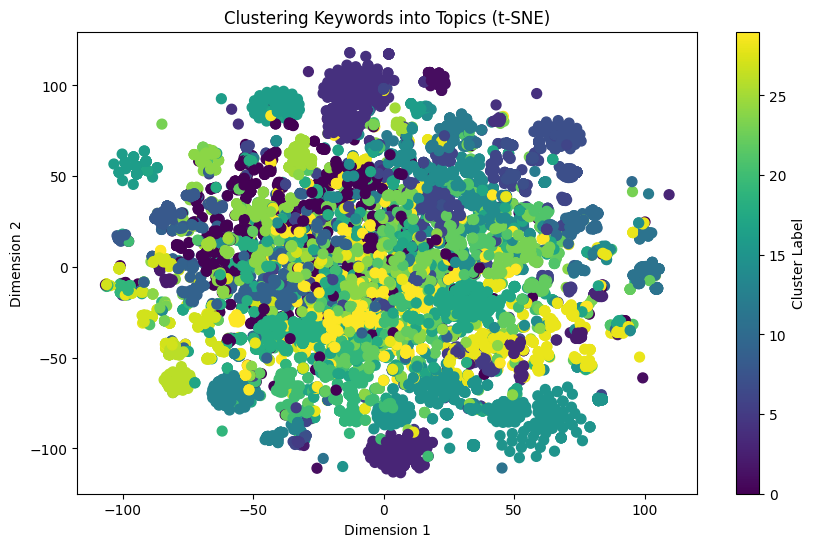

In [93]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1. Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=seed)
reduced_embeddings = tsne.fit_transform(embeddings)

# 2. Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(label='Cluster Label')
plt.title('Clustering Keywords into Topics (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

We are going to pick some word clusters that are meaningful, however split some of the subsets further.

Good subsets: 1 contrastive, 2 ood-domain, 4 graph learning, 8 diffusion, 10 language, 11 supervised, 12 rep learn, 13 adversarial robustness, 14 vision (add convolution), 15 RL (add multi-agent games, human-ai teaming, multi-armed bandits), 16 transformers, 18 entropy-opt, 25 generative, 26 bias fairness,

Moderate Subsets to split: 3 continual, 7 deep learning, 9 weird, 24 time series, 27 generalization, 28 idk

In [94]:
# 13 + 20 + 27 + 26 -> trustworthy ml
# 10 -> language
# 15 -> reinforcement
# 14 vision
# generative -> 25 + 8
# representation learning -> 1, 11, 12
# 4 -> graph learning and gnn

related_clusters = [15, 10, 14, 2, 3, 4, 8, 1, 13, 16, 20, 18, 24, 25, 11, 12, 26, 27]

cluster_dict = {i: [] for i in related_clusters}
for i, keyword in enumerate(all_keywords):
    if clusters[i] in related_clusters:
        cluster_dict[clusters[i]].append(keyword)

cluster_subsets = {i: list(set(cluster_dict[i])) for i in related_clusters}
# reorder the clusters based on the number of keywords
cluster_sizes = {i: len(cluster_dict[i]) for i in related_clusters}
cluster_sizes = dict(sorted(cluster_sizes.items(), key=lambda item: item[1], reverse=True))
related_clusters = list(cluster_sizes.keys())

cluster_subsets[8] += cluster_subsets[25]
cluster_subsets[1] += cluster_subsets[11] + cluster_subsets[12]


cluster_subsets[15] += ["goal-conditioned", "goal conditioned"]

cluster_subsets[14] += ["machine translation", 'image captioning', "vision transformer architecture", "motion", "cnn", "cnns", "convolutional", "convolutional neural network"]
cluster_subsets[10] += ["summarization", 'sentence semantic matching', 'open intent classification', ]

cluster_subsets[13] += cluster_subsets[20] + cluster_subsets[27] + cluster_subsets[26]
cluster_subsets[13] = list(set(cluster_subsets[13]))

In [95]:
if "cluster" not in df.columns:
    df["cluster"] = None
    
for index, paper in df.iterrows():
    paper_keywords = paper["keywords"]
    if pd.isna(paper_keywords):
        continue
    else:
        paper_keywords = paper_keywords.split(";")
        for cluster in related_clusters:
            for key in paper_keywords:
                if "vision" in key or "cnn" in key or "image" in key or "3d" in key:
                    df.at[index, "cluster"] = 14
                    break
                elif "generative" in key:
                    df.at[index, "cluster"] = 8
                    break
                elif "language" in key or "llm" in key:
                    df.at[index, "cluster"] = 10
                    break
                elif "graph" in key or "gnn" in key or "link " in key:
                    df.at[index, "cluster"] = 4
                    break
                elif "rl" in key or "pac-bayes" in key:
                    df.at[index, "cluster"] = 15
                    break
                elif key in cluster_subsets[cluster]:
                    df.at[index, "cluster"] = cluster
                    break

In [99]:
df["cluster"].value_counts()
# count non-NAN valued keyword rows

3796


# New dataframe